# Welcome to **PerfeCt** by AqADAPT team!
### To generate the interactive map and simulation graphical user interface, click on the *Restart the kernel, then re-run the whole notebook* button above or run the cells below consecutively using *Shift+Enter*.

**Loading the neccesary libraries**  
This cell loads all the necessary libraries for map display, interactive widgets handling, calculations, simulations and visualizations on Blue-Cloud.

In [1]:
%matplotlib widget
from ipyleaflet import *
import ipywidgets as widgets
from ipywidgets import HTML, Layout, IntSlider, RadioButtons, Dropdown, Button, Output, Label, IntProgress
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from pathlib import Path as pth
import pandas as pd
from perfect.perfect import perfect_sim
from vibrio.vibrio import calc_DRV
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as patches

**Variable setup**  
In this cell global variables are defined. This cell loads data on farm locations in the Mediterranean, Natura 2000 sites, and a custom 10 km x 10 km grid created for the possible farm locations in the Mediterranean based on the standard EEA grid. Moreover, timeseries data and species parameters necessary for simulations are loaded here.

In [2]:
x, y = 0, 0
feature_clicked = False
id_ = None

with open('data/MED_farms/MED_farms_for_display.geojson', 'r') as f:
    data_farms = json.load(f)
with open('data/Natura2000_marine/Natura2000_marine_smooth.geojson', 'r') as f:
    data_Natura = json.load(f)
with open('data/MED_grid/MED_ter_10km_grid.geojson', 'r') as f:
    data_grid = json.load(f)

# LOCAL pathing
time_series_dir_past = "/mnt/DataDisk/TIME_SERIES_PAST/"
time_series_dir_future = "/mnt/DataDisk/TIME_SERIES/"

# BLUECLOUD pathing
# time_series_dir_past = "data/TIME_SERIES_PAST/TIME_SERIES_PAST/"
# time_series_dir_future = "data/TIME_SERIES/TIME_SERIES/"

species_db = pd.read_csv("data/deb_species_list.csv", index_col=0)

species_mi = {}
for i in species_db.iloc:
    if not np.isnan(i["MarketWeight"]) and not np.isnan(i["InitialSize"]):
        species_mi[i["Name"]] = {
            "MarketWeight": i["MarketWeight"],
            "InitialSize": i["InitialSize"]
        }

**Map setup**  
The basic layers of the PerfeCt service are added to the map and map interaction event handling functions are created.

In [3]:
defaultLayout = Layout(width='1200px', height='500px')
center = (40,20)
icon = Icon(icon_url='', icon_size=[38, 95])
m = Map(center=center,
       basemap=basemaps.Esri.WorldImagery,
        zoom=4,
       layout=defaultLayout)

species_label = Label(layout=Layout(width="100%"))
title_label = HTML(value = """<p style='font-size:24px'>Welcome to PerfeCt!</p>

                   <p style='font-size:16px'> Instructions: </p>
                   <ol style='font-size:16px'><li>Click on an existing aquaculture farm denoted 
                   by blue markers or choose a blue square as a new farm location in 
                   the Mediterranean (zoom in for easier selection).</li> 
                   <li>Choose a fish species and a climate change scenario for which you would like to see the
                   model simulation results.</li>
                   <li>Click the Blue "Simulate!" button.</li>
                   <li>Wait up to 40 seconds to see the simulation results.</li>
                   </ol>
                   <p style='font-size:16px'>
                   Feel free to explore around the Mediterranean!
                   </p>
                   
                   """)

def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        global x
        global y
        global dummy_num
        global feature_clicked
        global temp_marker
        
        try:
            m.remove_layer(temp_marker)
        except:
            pass
        
        if feature_clicked == True:
            temp_marker = Marker(
                    location=kwargs.get('coordinates'),
                    icon=icon,
                    name="Location info")           
            #print("You clicked on: ", kwargs.get('coordinates'))

            x, y = kwargs.get('coordinates')
            message = HTML()
            message.value = f"Coordinates: ({np.round(x,2)}, {np.round(y,2)})"
            species_label.value = f"EEA field ID: {id_}"
            popup = Popup(
                location=(x, y),
                child=message,
                close_button=True,
                auto_close=True,
                close_on_escape_key=True,
                max_width = 500,
                name = "Location info"
            )
            m.add_layer(popup)
            m.add_layer(temp_marker)
        feature_clicked=False
        
m.on_interaction(handle_map_click)

geo_json_Natura = GeoJSON(
    data=data_Natura,
    style = {
        "fillOpacity": 0.75, "fillColor": "white", "color": "black", "weight": 1.5 
    },
    name="Natura2000 sites"
)

geo_json_grid = GeoJSON(
    data=data_grid,
    style = {
        "fillOpacity": 0.75, "fillColor": "#83d4e7", "color": "black", "weight": 0, "opacity": 0.5 
    },
    hover_style = {
        "fillOpacity": 0.75, "fillColor": "orange", "color": "white", "weight": 1, "opacity": 0.5 
    },
    name="Grid"
)

geo_json_farms = GeoJSON(
    data=data_farms,
    name="Farm locations"
)

def grid_click_handler(event=None, feature=None, id=None, properties=None):
    global id_
    global feature_clicked
    
    feature_clicked = True

    try:
        m.remove_layer(temp_marker)
    except:
        pass
    
    id_ = properties["CellCode"]
    #species_label.value = f"Field: {name}"

def marker_click_handler(event=None, feature=None, id=None, properties=None):
    global id_
    global feature_clicked
    global dummy_num
    global x
    global y

    try:
        m.remove_layer(temp_marker)
    except:
        pass
    #name = properties["geounit"]
    
    id_ = properties["farm_id"]
    
    species = properties["species"]
    if species == None:
        species = properties["species 1"]
    species_label.value = f"Species produced: {species}"
    
    x = properties["coordinates"][1]
    y = properties["coordinates"][0]
    
    message = HTML()
    message.value = f"Coordinates: ({np.round(x,2)}, {np.round(y,2)}) <br> Species: {species[species.find('(')+1:species.find(')')]}"
    popup = Popup(
            location=(x, y),
            child=message,
            close_button=True,
            auto_close=True,
            close_on_escape_key=True,
            max_width = 500,
            name = "Location info"
        )
    
    m.add_layer(popup)
    
geo_json_farms.on_click(marker_click_handler)
geo_json_grid.on_click(grid_click_handler)

m.add_layer(geo_json_Natura)
m.add_layer(geo_json_grid)
m.add_layer(geo_json_farms)

control = LayersControl(position='topright')
m.add_control(control)

**Simulation GUI setup**  
The simulation and visualization GUI is constructed here consisting of a species selection drop-down menu, climate change scenario selection radio buttons, simulation button, and visualization segment.

HTML(value='<p style=\'font-size:24px\'>Welcome to PerfeCt!</p>\n\n                   <p style=\'font-size:16p…

Map(bottom=1801.0, center=[39.977120098439634, 17.578125000000004], controls=(ZoomControl(options=['position',…

Label(value='Species produced: lubin (Dicentrarchus labrax)', layout=Layout(width='100%'))

Dropdown(description='Species:', options=('Argyrosomus_regius', 'Dentex_dentex', 'Dicentrarchus_labrax', 'Dipl…

RadioButtons(description='Scenario:', options=('RCP4.5', 'RCP8.5'), value='RCP4.5')

Button(button_style='primary', description='Simulate!', style=ButtonStyle())

IntProgress(value=0, max=4)

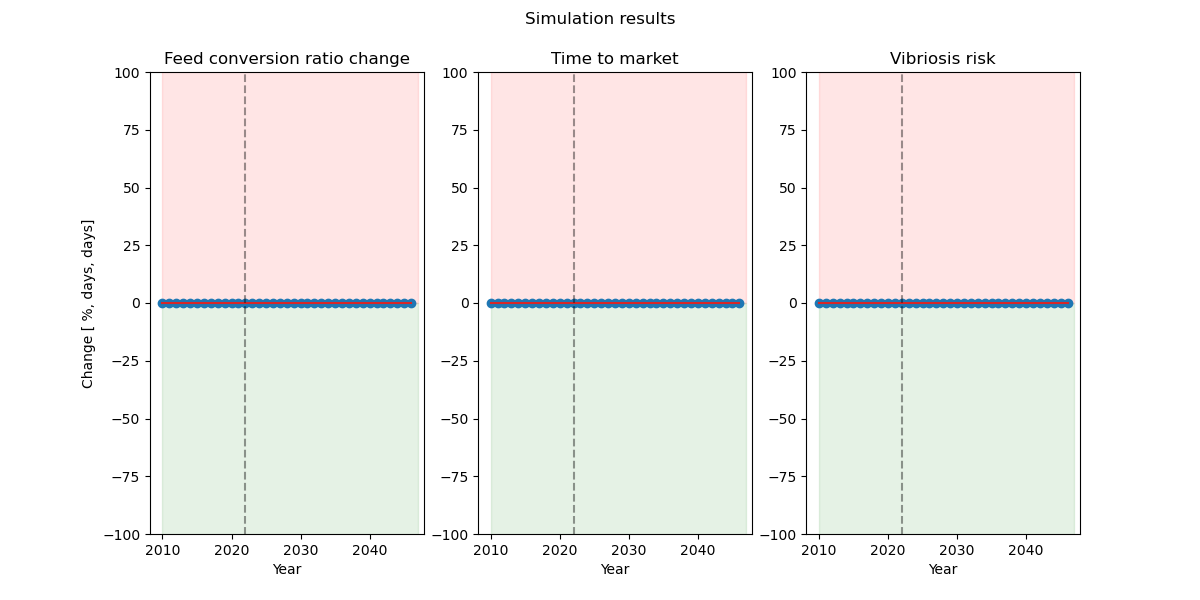

In [5]:
display(title_label)
display(m)
display(species_label)

options = list(species_mi.keys())

scenarios = ["RCP4.5", "RCP8.5"]

dropdown = Dropdown(
    options=options,
    value = options[0],
    description = "Species:",
    disabled = False)

radios = RadioButtons(
    options=scenarios,
    description="Scenario:",
    disabled=False
)

btn = Button(description="Simulate!", button_style="primary")
out = Output()

progress = IntProgress(min = 0, max=4)

display(dropdown)
display(radios)
display(btn)
display(progress)

max_y = 37

x_data = np.arange(2010, 2010+max_y, 1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
stem1 = ax[1].stem(x_data, np.zeros(max_y))
stem2 = ax[0].stem(x_data, np.zeros(max_y))
stem3 = ax[2].stem(x_data, np.zeros(max_y))
title1 = ax[1].set_title("Time to market")
title2 = ax[0].set_title("Feed conversion ratio change")
title3 = ax[2].set_title("Vibriosis risk")
ax[0].set_ylim(-100, 100)
ax[1].set_ylim(-100, 100)
ax[2].set_ylim(-100, 100)
ax[0].set_ylabel("Change [ %, days, days]")
ax[0].set_xlabel("Year")
ax[1].set_xlabel("Year")
ax[2].set_xlabel("Year")

ax[0].axvline(2022, -1000, 1000, c ="k", linestyle= "--", alpha = .4)
ax[1].axvline(2022, -1000, 1000, c ="k", linestyle= "--", alpha = .4)
ax[2].axvline(2022, -1000, 1000, c ="k", linestyle= "--", alpha = .4)

fig.suptitle("Simulation results")

rect = patches.Rectangle((2010, 0), max_y, -1000, linewidth=1, edgecolor='g', facecolor='g', alpha=.1)
ax[0].add_patch(rect)
rect = patches.Rectangle((2010, 0), max_y, 1000, linewidth=1, edgecolor='r', facecolor='r', alpha=.1)
ax[0].add_patch(rect)

rect = patches.Rectangle((2010, 0), max_y, -1000, linewidth=1, edgecolor='g', facecolor='g', alpha=.1)
ax[1].add_patch(rect)
rect = patches.Rectangle((2010, 0), max_y, 1000, linewidth=1, edgecolor='r', facecolor='r', alpha=.1)
ax[1].add_patch(rect)

rect = patches.Rectangle((2010, 0), max_y, -1000, linewidth=1, edgecolor='g', facecolor='g', alpha=.1)
ax[2].add_patch(rect)
rect = patches.Rectangle((2010, 0), max_y, 1000, linewidth=1, edgecolor='r', facecolor='r', alpha=.1)
ax[2].add_patch(rect)


last_species = ""


def update(change):
    progress.value = 0
    progress.value +=1
    try:
        data_file_past = time_series_dir_past + f"id_{id_:03d}.csv"
        data_file_future = time_series_dir_future + f"id_{id_:03d}.csv"
    except:
        data_file_past = time_series_dir_past + f"id_{id_}.csv"
        data_file_future = time_series_dir_future + f"id_{id_}.csv"
    species = "Sparus_aurata"

    # preprocessing
    data_past= pd.read_csv(data_file_past, index_col=0).values
    # print(data_past.shape)

    data_future = pd.read_csv(data_file_future, index_col=0).values
    # print(data_future.shape)

    data = np.zeros((len(data_past)+len(data_future), 2))
    data[:len(data_past), 0] = data_past[:, 1]
    data[:len(data_past), 1] = data_past[:, 1]
    data[len(data_past):, :] = data_future[:, 1:]

    dataframe = pd.DataFrame(data, columns=["rcp4_5", "rcp8_5"])

    ttm, fcr = perfect_sim(dataframe, species, species_mi[species], radios.value)
    progress.value +=1
    
    vibrio = calc_DRV(dataframe, radios.value)
    progress.value +=1
    

    y_data = ttm[:max_y]-ttm[12]
    stem1[0].set_ydata(y_data)
    stem1[1].set_paths(
        [np.array([[xx, 0], [xx, yy]]) for (xx, yy) in zip(x_data, y_data)])
    ax[1].set_ylim(np.min(y_data)-5, np.max(y_data)+5)
    
    y_data = ((fcr[:max_y]/fcr[12]) -1)*100
    stem2[0].set_ydata(y_data)
    stem2[1].set_paths(
        [np.array([[xx, 0], [xx, yy]]) for (xx, yy) in zip(x_data, y_data)])
    ax[0].set_ylim(np.min(y_data)-5, np.max(y_data)+5)
    
    y_data = (vibrio[:max_y]-vibrio[12])
    stem3[0].set_ydata(y_data)
    stem3[1].set_paths(
        [np.array([[xx, 0], [xx, yy]]) for (xx, yy) in zip(x_data, y_data)])
    ax[2].set_ylim(np.min(y_data)-5, np.max(y_data)+5)

    ax[1].set_title(f"Time to market")
    ax[0].set_title(f"Feed conversion ratio change")
    ax[2].set_title(f"Vibriosis risk")
    fig.suptitle("$\it{"+str(dropdown.value.replace("_", "\:"))+"}$"+ f" - Simulation results for location ({np.round(x,2)}, {np.round(y,2)}) - {radios.value}")
    fig.canvas.draw()
    progress.value+=1

    return


btn.on_click(update)